In [ ]:
#Name: 
#Rushabh Kothari B00974889
#Shruti Iyengar B00974747


In [ ]:
#The project is operating and the outputs are currently printed, accuray might vary based on 
#the model training. It is suggested to read comments before executing the cells
#In the below cells, for every models and class, I am using len(final_cols)-2 to give features based on their generation, it can be changed
#to number equal to the optimal features

In [6]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=7c258e55bbb64ca5ecb2e312ef9e1a8cb617e8c96282d5068f03229a76b54dc3
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

from ta import add_all_ta_features
from ta.utils import dropna
from scipy.stats import mstats

import statistics

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
import copy

import random
import pdb
random.seed(12345)

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### In order to read the files, we make a connection with the google drive and connect to the training / test data

In [8]:
### Change the path to your google drive
training_data_using_files = pd.concat([data_temp.assign(stock=i) for i,data_temp in enumerate(pd.read_pickle(r'/content/gdrive/MyDrive/stock market/training_set.pkl'))])
testing_data1_using_files = pd.concat([data_temp.assign(stock=i) for i,data_temp in enumerate(pd.read_pickle(r'/content/gdrive/MyDrive/stock market/testing_set1.pkl'))])
testing_data2_using_files = pd.concat([data_temp.assign(stock=i) for i,data_temp in enumerate(pd.read_pickle(r'/content/gdrive/MyDrive/stock market/testing_set2.pkl'))])

### Adhoc script to read from local

In [ ]:

'''training_data_using_files = pd.concat([data_temp.assign(stock=i) for i,data_temp in enumerate(pd.read_pickle(r'training_set.pkl'))])
testing_data1_using_files = pd.concat([df_temp.assign(stock=i) for i,df_temp in enumerate(pd.read_pickle(r'testing_set1.pkl'))])
testing_data2_using_files = pd.concat([df_temp.assign(stock=i) for i,df_temp in enumerate(pd.read_pickle(r'testing_set2.pkl'))])
'''

"training_data_using_files = pd.concat([data_temp.assign(stock=i) for i,data_temp in enumerate(pd.read_pickle(r'training_set.pkl'))])\ntesting_data1_using_files = pd.concat([df_temp.assign(stock=i) for i,df_temp in enumerate(pd.read_pickle(r'testing_set1.pkl'))])\ntesting_data2_using_files = pd.concat([df_temp.assign(stock=i) for i,df_temp in enumerate(pd.read_pickle(r'testing_set2.pkl'))])\n"

### Task 1

#### Calculating the pct change : which is the percentage change in the stock's closing price from the prev day's close

In [9]:
training_data_using_files['closing_price_pct_change'] = (training_data_using_files.groupby('stock')['Close']
                                  .apply(pd.Series.pct_change))
training_data_using_files.dropna(inplace=True)

#### Calculating the threshold for decrease/ no-big change/ increase in pct_change using the quantile function

In [ ]:
df_percentiles_dataset_using_files = training_data_using_files['closing_price_pct_change'].quantile([.66,0.33]).reset_index()
df_percentiles_dataset_using_files['stock'] = 'all'
df_percentiles_dataset_using_files = pd.pivot(df_percentiles_dataset_using_files, index='stock', columns='index', values='closing_price_pct_change').reset_index()
df_percentiles_dataset_using_files.columns = ['stock','0.33','0.66']
df_percentiles_dataset_using_files

,stock,0.33,0.66
0,all,-0.002165,0.001876


In [ ]:
float(df_percentiles_dataset_using_files['0.33'].values)

-0.0021645141875663576

#### Joining back to the data table to classiffy closing_price_pct_change in three categories

In [ ]:
df_train_w_percentile_using_the_files = training_data_using_files
df_train_w_percentile_using_the_files['0.33'] = float(df_percentiles_dataset_using_files['0.33'].values)
df_train_w_percentile_using_the_files['0.66'] = float(df_percentiles_dataset_using_files['0.66'].values)
df_train_w_percentile_using_the_files['change'] = 'no big change'
df_train_w_percentile_using_the_files.loc[df_train_w_percentile_using_the_files.closing_price_pct_change<df_train_w_percentile_using_the_files['0.33'],'change'] = 'decrease'
df_train_w_percentile_using_the_files.loc[df_train_w_percentile_using_the_files.closing_price_pct_change>df_train_w_percentile_using_the_files['0.66'],'change'] = 'increase'
df_train_w_percentile_using_the_files

,Open,High,Low,Close,Volume,stock,closing_price_pct_change,0.33,0.66,change
1,0.672106,0.674597,0.670546,0.672106,0.208023,0,0.000207,-0.002165,0.001876,no big change
2,0.672106,0.678621,0.671827,0.676282,0.142405,0,0.006214,-0.002165,0.001876,increase
3,0.676338,0.677340,0.672384,0.673498,0.146400,0,-0.004117,-0.002165,0.001876,decrease
4,0.673442,0.676004,0.672997,0.675892,0.116960,0,0.003555,-0.002165,0.001876,increase
5,0.675892,0.676115,0.673609,0.674890,0.205266,0,-0.001483,-0.002165,0.001876,no big change
...,...,...,...,...,...,...,...,...,...,...
2197,0.190271,0.192919,0.185970,0.186300,0.152329,1999,-0.021720,-0.002165,0.001876,decrease
2198,0.186300,0.186631,0.183322,0.183984,0.084532,1999,-0.012433,-0.002165,0.001876,decrease
2199,0.183984,0.184977,0.180675,0.181502,0.074575,1999,-0.013489,-0.002165,0.001876,decrease
2200,0.181502,0.182164,0.177697,0.179021,0.140368,1999,-0.013674,-0.002165,0.001876,decrease


#### Showing the thresholds and the number of datapoints per class

In [ ]:
# Here in the below table, the key column represents each stock, the 0.33 column is the upper bound for 'decrease' class, while the 0.66 is the lower bound for the 'increase' class
df_percentiles_dataset_using_files.head()

,stock,0.33,0.66
0,all,-0.002165,0.001876


In [ ]:
df_counts_after_reading_file = df_train_w_percentile_using_the_files[['stock','change']].groupby(['stock','change']).size().reset_index()
df_counts_after_reading_file = pd.pivot(df_counts_after_reading_file, index='stock', columns='change', values=0).reset_index()
df_counts_after_reading_file.columns = ['stock','decrease count','increase count','no big change count']
df_counts_after_reading_file

,stock,decrease count,increase count,no big change count
0,0,600.0,694.0,907.0
1,1,848.0,907.0,446.0
2,2,256.0,321.0,1624.0
3,3,803.0,827.0,571.0
4,4,863.0,865.0,473.0
...,...,...,...,...
1995,1995,858.0,882.0,461.0
1996,1996,694.0,710.0,797.0
1997,1997,485.0,503.0,1213.0
1998,1998,626.0,727.0,848.0


After making the buckets, we've been able to divide the dataset into three classes with roughly equal number of datapoints (~726-748)

### Task 2

#### Creating features
We define a function which takes a dataframe as input and then creates a set of features based on OHLC data (only considering the last 100 rows)

In [ ]:
def create_feature_set_based_on_files(data):

  # our first set of features would be the deviation of open/high/low/close price from their historical averages
  data['Open_dev'] = data['Open'] - np.mean(data['Open'])
  data['High_dev'] = data['High'] - np.mean(data['High'])
  data['Low_dev'] = data['Low'] - np.mean(data['Low'])
  data['Close_dev'] = data['Close'] - np.mean(data['Close'])

  # next we include some standard statistical measures (range/stdev) against each of the OHLC metric
  data['Open_range'] = max(data["Open"]) - max(data["Open"])
  
  data['High_range'] = max(data["High"]) - max(data["High"])
  
  data['Low_range'] = max(data["Low"]) - max(data["Low"])
  
  data['Close_range'] = max(data["Close"]) - max(data["Close"])
  
  # we now add features between the difference of open and close, open and high, open and low, high and low, high and close, low and close
  data['diff_oc'] = data['Open'] - data['Close']
  data['diff_oh'] = data['Open'] - data['High']
  data['diff_ol'] = data['Open'] - data['Low']
  data["diff_hc"] = data['High'] - data['Close']
  data['diff_hl'] = data['High'] - data['Low']
  data['diff_lc'] = data['Low'] - data['Close']

  # we will now add a few financial indicators using the 'ta' package
  data = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
  
  #return data
  
  data = data[[
      'stock','Open', 'High', 'Low', 'Close', 'Volume', 'Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','High_range','Low_range','Close_range',
      'diff_oc', 'diff_oh', 'diff_ol', 'diff_hc', 'diff_hl', 'diff_lc',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr','change'
  ]]
  
  return data


In [ ]:
def get_last100_features(df):
  df_output = pd.DataFrame()
  #print (123)
  for i in range(100,len(df)):
    #print(i)
    df_temp = create_feature_set_based_on_files(df.loc[i-99:i,:])
    df_output.append(df_temp.tail(1))
  df_output


In the below output, we see how the feature set looks like for the first stock (last five rows), the last column is our dependent variable

In [ ]:
df_train_w_percentile_using_the_files[df_train_w_percentile_using_the_files.stock.isin([0])].groupby('stock').apply(lambda grp: create_feature_set_based_on_files(grp)).tail()

,stock,Open,High,Low,Close,Volume,Open_dev,High_dev,Low_dev,Close_dev,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,change
2197,0,0.680849,0.683633,0.672997,0.674055,0.351048,-0.117817,-0.117773,-0.122780,-0.124504,...,-0.325075,0.436471,1.755036,4.373958,-2.618922,0.671096,-1.014064,-1.019241,0.289998,decrease
2198,0,0.674389,0.674890,0.671326,0.674055,0.143069,-0.124277,-0.126516,-0.124451,-0.124504,...,-0.234243,0.363327,-3.791546,2.740857,-6.532403,0.671359,0.000000,0.000000,0.289998,no big change
2199,0,0.674110,0.676227,0.672440,0.676004,0.312048,-0.124555,-0.125180,-0.123337,-0.122555,...,-0.154480,0.319055,-4.651307,1.262424,-5.913731,0.671891,0.289159,0.288742,0.579996,increase
2200,0,0.675725,0.675837,0.668820,0.669321,0.279230,-0.122940,-0.125570,-0.126957,-0.129237,...,-0.101340,0.212561,-6.048075,-0.199676,-5.848399,0.671808,-0.988547,-0.993465,-0.414285,decrease
2201,0,0.669293,0.671326,0.662973,0.664198,0.552933,-0.129372,-0.130080,-0.132804,-0.134361,...,-0.079619,0.086881,-0.997003,-0.359141,-0.637862,0.671383,-0.765460,-0.768404,-1.176573,decrease


We need to generate the features for all of the 2000 stocks, this takes sometime (~45min), thus we've stored the output post this stage as a csv file

In [ ]:
df_train_w_features = df_train_w_percentile_using_the_files[df_train_w_percentile_using_the_files.stock.isin(range(0,200))].groupby('stock').apply(lambda grp: create_feature_set_based_on_files(grp))

Getting the dependent variable by a lead function

In [ ]:
df_train_w_features['y'] = df_train_w_features.groupby(['stock'])['change'].shift(-1)

In [ ]:
## This code is just to save the processed data onto gdrive, so that we can pick it up directly
df_train_w_features.to_parquet('/content/gdrive/MyDrive/stock market/training_data_with_features.parquet',index=False)

### Task 3: Training Predictive Models

In [ ]:
df_train_w_features = pd.read_parquet('/content/gdrive/MyDrive/stock market/training_data_with_features.parquet')

In [ ]:
df_train_w_features

,stock,Open,High,Low,Close,Volume,Open_dev,High_dev,Low_dev,Close_dev,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,change,y
0,0,0.672106,0.674597,0.670546,0.672106,0.208023,-0.126560,-0.126809,-0.125231,-0.126453,...,0.000000,0.000000,0.000000,0.000000,0.672106,-15.835127,0.000000,0.000000,no big change,increase
1,0,0.672106,0.678621,0.671827,0.676282,0.142405,-0.126560,-0.122785,-0.123950,-0.122276,...,0.039640,-2.576511,-0.515302,-2.061209,0.672141,0.621427,0.619504,0.621427,increase,decrease
2,0,0.676338,0.677340,0.672384,0.673498,0.146400,-0.122328,-0.124066,-0.123393,-0.125061,...,0.035885,-4.502110,-1.312664,-3.189446,0.672153,-0.411726,-0.412576,0.207142,decrease,increase
3,0,0.673442,0.676004,0.672997,0.675892,0.116960,-0.125224,-0.125403,-0.122780,-0.122666,...,0.054180,-7.320689,-2.514269,-4.806420,0.672396,0.355548,0.354918,0.563427,increase,no big change
4,0,0.675892,0.676115,0.673609,0.674890,0.205266,-0.122773,-0.125291,-0.122168,-0.123668,...,0.052997,-5.655461,-3.142507,-2.512954,0.672571,-0.148307,-0.148417,0.414285,no big change,decrease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440195,199,0.884484,0.885003,0.881371,0.881544,0.042086,-0.070067,-0.070448,-0.072175,-0.072963,...,0.085642,-19.085130,-6.471100,-12.614030,0.885193,-0.176264,-0.176419,-2.735876,no big change,no big change
440196,199,0.881285,0.882236,0.880160,0.881996,0.008188,-0.073267,-0.073215,-0.073385,-0.072512,...,0.058728,-25.085746,-10.194029,-14.891716,0.885121,0.051207,0.051194,-2.686071,no big change,decrease
440197,199,0.882236,0.882461,0.879815,0.879988,0.020354,-0.072316,-0.072990,-0.073731,-0.074520,...,0.026136,-28.879316,-13.931087,-14.948229,0.885078,-0.227665,-0.227925,-2.907620,decrease,decrease
440198,199,0.879685,0.880005,0.876355,0.876355,0.017706,-0.074867,-0.075446,-0.077190,-0.078152,...,-0.020136,-32.490049,-17.642879,-14.847170,0.884474,-0.412742,-0.413596,-3.308361,decrease,decrease


#### For our dependent variable, we consider increase as positive (1), no change and decrease are considered as negative (0)

In [ ]:
df_train_w_features['y_level'] = 0
df_train_w_features.loc[df_train_w_features.y=='increase','y_level'] = 1
df_train_w_features
df_train_w_features['index'] = df_train_w_features.index

In [ ]:
x_cols = ['Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','High_range','Low_range','Close_range',
      'diff_oc', 'diff_oh', 'diff_ol', 'diff_hc', 'diff_hl', 'diff_lc',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr'
  ]

y_col = ['y_level']

In [ ]:
df_training = df_train_w_features[['stock','Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','High_range','Low_range','Close_range',
      'diff_oc', 'diff_oh', 'diff_ol', 'diff_hc', 'diff_hl', 'diff_lc',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr','y_level']]

In [ ]:
df_training

,stock,Open_dev,High_dev,Low_dev,Close_dev,Open_range,High_range,Low_range,Close_range,diff_oc,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,y_level
0,0,-0.126560,-0.126809,-0.125231,-0.126453,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.672106,-15.835127,0.000000,0.000000,1
1,0,-0.126560,-0.122785,-0.123950,-0.122276,0.0,0.0,0.0,0.0,-0.004177,...,0.009910,0.039640,-2.576511,-0.515302,-2.061209,0.672141,0.621427,0.619504,0.621427,0
2,0,-0.122328,-0.124066,-0.123393,-0.125061,0.0,0.0,0.0,0.0,0.002840,...,0.018881,0.035885,-4.502110,-1.312664,-3.189446,0.672153,-0.411726,-0.412576,0.207142,1
3,0,-0.125224,-0.125403,-0.122780,-0.122666,0.0,0.0,0.0,0.0,-0.002450,...,0.032426,0.054180,-7.320689,-2.514269,-4.806420,0.672396,0.355548,0.354918,0.563427,0
4,0,-0.122773,-0.125291,-0.122168,-0.123668,0.0,0.0,0.0,0.0,0.001002,...,0.045676,0.052997,-5.655461,-3.142507,-2.512954,0.672571,-0.148307,-0.148417,0.414285,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440195,199,-0.070067,-0.070448,-0.072175,-0.072963,0.0,0.0,0.0,0.0,0.002940,...,-0.219329,0.085642,-19.085130,-6.471100,-12.614030,0.885193,-0.176264,-0.176419,-2.735876,0
440196,199,-0.073267,-0.073215,-0.073385,-0.072512,0.0,0.0,0.0,0.0,-0.000711,...,-0.204647,0.058728,-25.085746,-10.194029,-14.891716,0.885121,0.051207,0.051194,-2.686071,0
440197,199,-0.072316,-0.072990,-0.073731,-0.074520,0.0,0.0,0.0,0.0,0.002248,...,-0.198113,0.026136,-28.879316,-13.931087,-14.948229,0.885078,-0.227665,-0.227925,-2.907620,0
440198,199,-0.074867,-0.075446,-0.077190,-0.078152,0.0,0.0,0.0,0.0,0.003329,...,-0.203147,-0.020136,-32.490049,-17.642879,-14.847170,0.884474,-0.412742,-0.413596,-3.308361,0


#### We create a function which passes the data in a rolling manner with the last 100 rows and labels together

In [ ]:
df_training_roll = pd.DataFrame()
for i in df_training.stock.unique():
    df_training_temp = pd.DataFrame()
    df_temp = df_training[df_training.stock==i].reset_index()
    df_training_x = df_temp[x_cols]
    x_lists = []
    y_list = []
    for j in range(100,len(df_temp)):
        x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
        #print ()
        y_list.append(df_temp.loc[j,'y_level'])

    df_training_temp['x'] = x_lists
    df_training_temp['y'] = y_list
    df_training_temp['stock'] = i

    df_training_roll = df_training_roll.append(df_training_temp)
    
df_training_roll = df_training_roll.reset_index()
df_training_roll = df_training_roll[['stock','x','y']]
df_training_roll['index'] = df_training_roll.index

In [ ]:
df_training_roll.head()

,stock,x,y,index
0,0,"[[-0.12656004095632933, -0.1227853043076167, -...",0,0
1,0,"[[-0.12232773892460003, -0.12406616050604802, ...",0,1
2,0,"[[-0.1252235267614159, -0.12540267470096156, -...",0,2
3,0,"[[-0.12277321533155772, -0.12529127373395688, ...",0,3
4,0,"[[-0.12366425311951346, -0.1257367926279348, -...",0,4


In [ ]:
validation_index = df_training_roll.groupby(['stock']).apply(lambda x: x.sample(frac=0.30)).reset_index(drop=True)['index']

In [ ]:
data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

#### At first we train some Tree and gradient boosting based based models. 
These take in 1-d data as input, we thus have to flatten our data to fit into a 1d framework. For the SVC models we use the balanced class weight argument to ensure that the data is balanced

In [ ]:
def flatten_array_simple_using_files(arr_in,lookback = 1,max_num=100):
    arr_out = []
    for i in range(lookback):
        #print (arr_in,i,max_num)
        arr_temp = arr_in[max_num-i-1]
        arr_out.extend(arr_temp)
    return arr_out

def flatten_array_max_using_files(arr_in,max_num=100):
    arr_out = []
    arr_out = arr_in[max_num-1]
    arr_out_2 = np.max(arr_in[:max_num],axis=0)
    arr_out.extend(arr_out_2)
    return arr_out

def get_output_parameters(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    positive_share = sum(y_pred)/len(y_pred)

    return [accuracy,precision,positive_share]

In [ ]:
def basic_classifiers_flatten_as_per_files(data_train,data_test,type = 'none',lookback = 100,frac=0.1,hyperparameter_tune = True):  

    '''
    inputs 

    data_train - training data
    data_test - testing data
    type - type of flattening to be done,
        none : no flattening only take last row
        simple : just extend feature set adding in lagged terms
        max : take latest obs as it is and the max for each column in past
    lookback - number of historical rows to take into account

    output

    parameters related to different models trained
    '''

    ## taking 10% sample to increase training time
    data_train = data_train.groupby(['y']).apply(lambda x: x.sample(frac=frac)).reset_index(drop=True)
    data_test = data_test.sample(frac=frac)

    if type=='none':
        
        x_train = [flatten_array_simple_using_files(a) for a in data_train['x']]
        #print (1)
        x_test = [flatten_array_simple_using_files(a) for a in data_test['x']]

        y_train = data_train['y']
        y_test = data_test['y']
    elif type == 'simple':
        x_train = flatten_array_simple_using_files(data_train['x'],lookback=lookback)
        x_test = flatten_array_simple_using_files(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']
    else:
        x_train = flatten_array_max_using_files(data_train['x'],lookback=lookback)
        x_test = flatten_array_max_using_files(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']

    output_list = []
    
    
    #balanced bagging 

    param_grid_lr = {
        'penalty' : ['l1','l2', 'elasticnet', None],
        'C' : [1,0.1,0.01],
        'class_weight': ['balanced']

    }

    #svc_model = SVC(random_state=0, tol=1e-5,class_weight='balanced')
    param_grid_svm = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf'],
              'class_weight':['balanced']} 
   
    param_grid_ada = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

    
    params_xgb = {
        'min_child_weight': [1, 5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6,  1.0],
        'max_depth': [3,  5]
        }
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    if (hyperparameter_tune):
        lr_model  = GridSearchCV(LogisticRegression(), param_grid_lr, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')
        ada_model = GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)), param_grid_ada, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')
        xgb_model = GridSearchCV(XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1), params_xgb, refit = True,n_jobs=-1,cv=cv, verbose = 3,scoring='precision')
        svc_model = GridSearchCV(SVC(), param_grid_svm, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')

    
    else:
        lr_model = LogisticRegression(class_weight='balanced')
        svc_model = SVC(class_weight='balanced')
        ada_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
        xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)


    lr_model.fit(x_train, y_train)
    y_pred_lr = lr_model.predict(x_test)
    y_pred_lr_train = lr_model.predict(x_train) 
    lr_output_temp = get_output_parameters(y_pred_lr,y_test).extend(get_output_parameters(y_pred_lr_train,y_train))
    lr_output =  (get_output_parameters(y_pred_lr,y_test))
    lr_output.extend(get_output_parameters(y_pred_lr_train,y_train))
    output_list.append(lr_output)

    svc_model.fit(x_train, y_train)
    y_pred_svc = svc_model.predict(x_test) 
    y_pred_svc_train = svc_model.predict(x_train) 
    svc_output_temp = get_output_parameters(y_pred_svc,y_test)
    svc_output_temp.extend(get_output_parameters(y_pred_svc_train,y_train))
    output_list.append(svc_output_temp)
    
    
    ada_model.fit(x_train,y_train)
    y_pred_ada_model = ada_model.predict(x_test)
    y_pred_ada_train = ada_model.predict(x_train) 
    ada_output_temp = get_output_parameters(y_pred_ada_model,y_test)
    ada_output_temp.extend(get_output_parameters(y_pred_ada_train,y_train))
    output_list.append(ada_output_temp)



    
    xgb_model.fit(x_train,y_train)
    y_pred_xgb_model = xgb_model.predict(x_test)
    y_pred_xgb_train = xgb_model.predict(x_train)
    xgb_output_temp = get_output_parameters(y_pred_xgb_model,y_test)
    xgb_output_temp.extend(get_output_parameters(y_pred_xgb_train,y_train))
    output_list.append(xgb_output_temp)

    df_output = pd.DataFrame(output_list)
    #df_output.columns = ['accuracy_score','precision_score','positive_share']
    df_output['models'] = ['lr','svc','ada','xgb']
    
    return (df_output)

In [ ]:
df_output = pd.DataFrame()
for i in tqdm(data_train.stock.unique()[0:5]):
    df_temp = basic_classifiers_flatten_as_per_files(data_train[data_train.stock==i],data_test[data_test.stock==i])
    df_temp['stock'] = i
    df_output = df_output.append(df_temp)

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[00:30:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



 20%|██        | 1/5 [01:25<05:41, 85.34s/it]

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[00:31:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



 40%|████      | 2/5 [02:50<04:14, 84.98s/it]

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[00:32:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



 60%|██████    | 3/5 [04:02<02:38, 79.07s/it]

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[00:34:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



 80%|████████  | 4/5 [05:26<01:21, 81.04s/it]

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[00:35:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



100%|██████████| 5/5 [06:48<00:00, 81.77s/it]


In [ ]:
df_output.columns = ['Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share','models','stock']

In [ ]:
df_output

,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,models,stock
0,0.619048,0.596429,0.444444,0.612245,0.578390,0.401361,lr,0
1,0.285714,0.142857,1.000000,0.312925,0.156463,1.000000,svc,0
2,0.619048,0.547093,0.317460,1.000000,1.000000,0.312925,ada,0
3,0.650794,0.508491,0.158730,1.000000,1.000000,0.312925,xgb,0
0,0.476190,0.504211,0.603175,0.632653,0.624579,0.448980,lr,1
1,0.365079,0.182540,1.000000,0.408163,0.204082,1.000000,svc,1
2,0.523810,0.521673,0.492063,1.000000,1.000000,0.408163,ada,1
3,0.492063,0.481237,0.460317,1.000000,1.000000,0.408163,xgb,1
0,0.714286,0.533333,0.285714,0.666667,0.581243,0.367347,lr,2
1,0.063492,0.031746,1.000000,0.156463,0.078231,1.000000,svc,2


In [ ]:
df_basic_models_using_files = df_output.groupby(['models']).agg('median').reset_index().sort_values(['Test_precision'])
df_basic_models_using_files

,models,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock
2,svc,0.365079,0.182540,1.000000,0.367347,0.183673,1.000000,2.0
3,xgb,0.603175,0.508491,0.349206,1.000000,1.000000,0.367347,2.0
0,ada,0.523810,0.521673,0.317460,1.000000,1.000000,0.367347,2.0
1,lr,0.619048,0.555444,0.507937,0.646259,0.623789,0.401361,2.0


In [ ]:
'''
try_train = data_train[data_train.stock==51]
try_test = data_test[data_test.stock==2]

train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.06)).reset_index(drop=True)
test_try = try_test.sample(frac=0.1)

x_train = [flatten_array_simple_using_files(a) for a in try_train['x']]
#print (1)
x_test = [flatten_array_simple_using_files(a) for a in try_test['x']]

y_train = try_train['y']
y_test = try_test['y']

encoder = LabelEncoder()
encoder.fit(y_train)
y = encoder.transform(y_train)

X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
'''

"\ntry_train = data_train[data_train.stock==51]\ntry_test = data_test[data_test.stock==2]\n\ntrain_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.06)).reset_index(drop=True)\ntest_try = try_test.sample(frac=0.1)\n\nx_train = [flatten_array_simple_using_files(a) for a in try_train['x']]\n#print (1)\nx_test = [flatten_array_simple_using_files(a) for a in try_test['x']]\n\ny_train = try_train['y']\ny_test = try_test['y']\n\nencoder = LabelEncoder()\nencoder.fit(y_train)\ny = encoder.transform(y_train)\n\nX = torch.tensor(x_train, dtype=torch.float32)\ny = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)\n"

In [ ]:
# Define two models
class Wide_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(100, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
# Define two models
class Wide_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(100, 200)
        self.relu = nn.ReLU()
        self.output = nn.Linear(200, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(100, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

class Deep_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(100, 30)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(100, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 

In [ ]:
# Compare model sizes
model_1 = Wide_1()
model_2 = Wide_2()
model_3 = Wide_3()
model_4 = Deep_1()
model_4 = Deep_2()
model_4 = Deep_3()
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 30   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_pres = - np.inf
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        #print (y_pred.round().detach().numpy())
        pres = precision_score(y_pred.round().detach(), y_val, average='macro')
        share_pos = sum(y_pred.round().detach())/len(y_pred.round().detach())
        if pres > best_pres:
            best_pres = pres
            #print (best_pres)
            best_weights = copy.deepcopy(model.state_dict())
            best_acc = acc
    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    y_train_pred = model(X_train).round().detach()
    y_test_pred = model(X_val).round().detach()

    pres_train = precision_score(y_train_pred,y_train, average = 'macro')
    pres_test = precision_score(y_test_pred,y_val, average = 'macro')

    acc_train = accuracy_score(y_train_pred,y_train)
    acc_test = accuracy_score(y_test_pred,y_val)

    share_pos_train = sum(y_train_pred.round().detach())/len(y_train_pred.round().detach())
    share_pos_test = sum(y_test_pred.round().detach())/len(y_test_pred.round().detach())


    return pres_train,pres_test,acc_train,acc_test,share_pos_train,share_pos_test
 
 

In [ ]:
def nn_preprocess(df_train,key,fraction=0.1):
    try_train = df_train[df_train.stock==key]

    train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

    x_train = [flatten_array_simple_using_files(a) for a in try_train['x']]

    y_train = try_train['y']
    # y_test = try_test['y']

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    X = torch.tensor(x_train, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

    return X_train,X_test,y_train,y_test

In [ ]:
def get_nn_model_output(df_train,key):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)

    X_train,X_test,y_train,y_test = nn_preprocess(df_train,key)

    pres_scores = []
    acc_scores = []
    pos_share = []

    for i in ([Wide_1(),Wide_2(),Wide_3(),Deep_1(),Deep_2(),Deep_3()]):
        pres_temp = []
        acc_temp = []
        pos_temp = []
        for train, test in kfold.split(X_train, y_train):
            # create model, train, and get accuracy
            model = i
            pres_train,pres_test,acc_train,acc_test,share_pos_train,share_pos_test = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
            #print("Precision: %.2f" % pres)
            pres_temp.append([pres_train,pres_test])
            acc_temp.append([acc_train,acc_test])
            pos_temp.append([share_pos_train,share_pos_test])

            
        pres_scores.append([float(sum(l))/len(l) for l in zip(*pres_temp)])
        acc_scores.append([float(sum(l))/len(l) for l in zip(*acc_temp)])
        pos_share.append([float(sum(l))/len(l) for l in zip(*pos_temp)])

    df_pres = pd.DataFrame(pres_scores)
    df_acc = pd.DataFrame(acc_scores)
    df_share = pd.DataFrame(pos_share)

    df_output = pd.concat([df_pres, df_acc,df_share], axis=1)

    df_output.columns = ['Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']

    df_output['Model'] = ['Wide_1','Wide_2','Wide_3','Deep_1','Deep_2','Deep_3']
    df_output['key'] = key
    df_output = df_output[['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    return (df_output)

In [ ]:
df_final_output_nn = pd.DataFrame(columns=['stock','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(df_training_roll.stock.unique()[0:5]):
    df_temp = get_nn_model_output(df_training_roll,key=i)
    df_final_output_nn = pd.concat([df_final_output_nn,df_temp])

100%|██████████| 5/5 [12:23<00:00, 148.76s/it]


In [ ]:
df_dl_output = df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

In [ ]:
df_dl_output.columns = ['models','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share','stock']

In [ ]:
df_output_final = df_basic_models_using_files.append(df_dl_output)
df_output_final

,models,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock
2,svc,0.365079,0.182540,1.000000,0.367347,0.183673,1.000000,2.0
3,xgb,0.603175,0.508491,0.349206,1.000000,1.000000,0.367347,2.0
0,ada,0.523810,0.521673,0.317460,1.000000,1.000000,0.367347,2.0
1,lr,0.619048,0.555444,0.507937,0.646259,0.623789,0.401361,2.0
5,Wide_3,0.521389,0.541427,0.531973,0.545578,0.562585,0.583673,2.0
1,Deep_2,0.543323,0.542446,0.610204,0.602041,0.245918,0.246258,2.0
0,Deep_1,0.547094,0.546005,0.606122,0.594558,0.315136,0.325850,2.0
2,Deep_3,0.540243,0.546647,0.603231,0.596599,0.306633,0.299320,2.0
4,Wide_2,0.548902,0.558773,0.550680,0.560544,0.460204,0.477551,2.0
3,Wide_1,0.538018,0.559226,0.538776,0.554422,0.484014,0.472109,2.0


### Feature Engineering

In [ ]:
df_initial = df_train_w_features.drop(['y','change','index'],axis=1)
df_correlation = df_initial.groupby('stock').corr().abs().reset_index()

In [ ]:
df_cor = df_correlation.drop(['stock'],axis=1).fillna(np.inf).groupby('level_1').median().replace(np.inf, np.nan).reset_index()
df_cor.index = df_cor.level_1
df_cor.drop(['level_1'],axis=1,inplace=True)

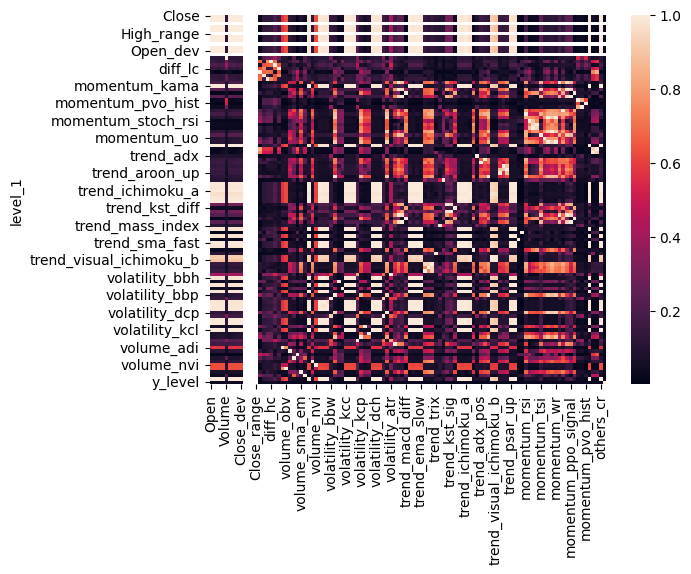

In [ ]:
import seaborn as sns
sns.heatmap(df_cor, annot=False)
plt.show()

In [ ]:
upper = df_cor.where(np.triu(np.ones(df_cor.shape), k=1).astype(bool))

# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
df_non_corr = df_initial.drop(to_drop,axis=1)

In [ ]:
df_non_corr

,stock,Open,Volume,Open_range,High_range,Low_range,Close_range,diff_oc,diff_oh,diff_ol,...,volatility_kcli,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,y_level
0,0,0.672106,0.208023,0.0,0.0,0.0,0.0,0.000000,-0.002491,0.001559,...,0.0,0.602696,0.384934,0.000000,0.000000,0.000000,0.000000,0.000000,-15.837308,1
1,0,0.672106,0.142405,0.0,0.0,0.0,0.0,-0.004177,-0.006516,0.000278,...,0.0,1.197701,0.710345,0.000000,0.000000,0.059900,0.020548,0.039352,0.001214,0
2,0,0.676338,0.146400,0.0,0.0,0.0,0.0,0.002840,-0.001002,0.003954,...,0.0,1.198114,0.365517,0.000000,0.000000,0.097222,0.064446,0.032776,0.002377,1
3,0,0.673442,0.116960,0.0,0.0,0.0,0.0,-0.002450,-0.002562,0.000446,...,0.0,1.197256,0.662070,0.000000,0.000000,0.120528,0.093513,0.027015,0.004147,0
4,0,0.675892,0.205266,0.0,0.0,0.0,0.0,0.001002,-0.000223,0.002283,...,0.0,1.197098,0.537931,0.000000,0.000000,0.139916,0.108383,0.031533,0.005949,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440195,199,0.884484,0.042086,0.0,0.0,0.0,0.0,0.002940,-0.000519,0.003113,...,1.0,1.583228,0.344143,0.003323,0.703400,1.053675,0.949315,0.104360,-0.033473,0
440196,199,0.881285,0.008188,0.0,0.0,0.0,0.0,-0.000711,-0.000951,0.001124,...,1.0,1.583279,0.376442,0.003198,0.692919,0.996075,1.019621,-0.023546,-0.030523,0
440197,199,0.882236,0.020354,0.0,0.0,0.0,0.0,0.002248,-0.000225,0.002421,...,1.0,1.583245,0.232771,0.003143,0.697880,0.968992,0.998851,-0.029858,-0.028703,0
440198,199,0.879685,0.017706,0.0,0.0,0.0,0.0,0.003329,-0.000320,0.003329,...,1.0,1.626319,0.000000,0.003194,0.724022,0.963835,1.046372,-0.082538,-0.028465,0


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

df_sample = df_non_corr.sample(frac=0.01)
X = df_sample.drop(['stock','y_level'],axis=1)
y = df_sample['y_level']

min_features_to_select = 5  # Minimum number of features to consider
clf = tree.DecisionTreeClassifier(class_weight='balanced')
cv = StratifiedKFold(5)

random.seed(12345)

rfecv = RFECV(
    estimator=clf,
    step=2,
    cv=cv,
    scoring="precision",
    min_features_to_select=min_features_to_select,
    n_jobs=5
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 12


In [ ]:
df_feature_summary = pd.DataFrame()
df_feature_summary['columns'] = X.columns
df_feature_summary['selected'] = rfecv.support_
df_feature_summary['rank'] = rfecv.ranking_
df_feature_summary = df_feature_summary.sort_values(by='rank').reset_index()

final_cols = list(df_feature_summary[df_feature_summary.selected]['columns'])

final_cols.extend(['stock','y_level'])

df_training_selected_features = df_non_corr[final_cols]

In [ ]:
final_cols

['Open',
 'trend_vortex_ind_neg',
 'volatility_ui',
 'volatility_atr',
 'volatility_kcp',
 'volatility_kcw',
 'volatility_bbp',
 'volume_cmf',
 'volume_adi',
 'volume_mfi',
 'diff_oh',
 'diff_ol',
 'stock',
 'y_level']

In [ ]:
x_cols = list(df_feature_summary[df_feature_summary.selected]['columns'])

In [ ]:
df_training_roll = pd.DataFrame()
for i in tqdm(df_training_selected_features.stock.unique()):
    df_training_temp = pd.DataFrame()
    df_temp = df_training_selected_features[df_training_selected_features.stock==i].reset_index()
    df_training_x = df_temp[x_cols]
    x_lists = []
    y_list = []
    for j in range(100,len(df_temp)):
        x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
        #print ()
        y_list.append(df_temp.loc[j,'y_level'])

    df_training_temp['x'] = x_lists
    df_training_temp['y'] = y_list
    df_training_temp['stock'] = i

    df_training_roll = df_training_roll.append(df_training_temp)
    
df_training_roll = df_training_roll.reset_index()
df_training_roll = df_training_roll[['stock','x','y']]
df_training_roll['index'] = df_training_roll.index

100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


In [ ]:
validation_index = df_training_roll.groupby(['stock']).apply(lambda x: x.sample(frac=0.33)).reset_index(drop=True)['index']

data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

df_output = pd.DataFrame()
for i in tqdm(data_train.stock.unique()[0:2]):
    df_temp = basic_classifiers_flatten_as_per_files(data_train[data_train.stock==i],data_test[data_test.stock==i],frac=0.01)
    df_temp['stock'] = i
    df_output = df_output.append(df_temp)



  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 15 folds for each of 8 candidates, totalling 120 fits


 50%|█████     | 1/2 [00:12<00:12, 12.59s/it]

[00:49:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fitting 15 folds for each of 8 candidates, totalling 120 fits


100%|██████████| 2/2 [00:22<00:00, 11.41s/it]

[00:49:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [ ]:
df_output.columns = ['Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share','models','stock']

In [ ]:
## showing aggregated performance for all models
df_basic_models_using_files = df_output.groupby(['models']).agg('median')
df_basic_models_using_files

,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock
models,,,,,,,
ada,0.571429,0.550000,0.285714,1.000000,1.000000,0.380952,0.5
lr,0.285714,0.166667,0.285714,0.759524,0.744444,0.345238,0.5
svc,0.285714,0.212500,0.428571,0.652381,0.653274,0.519048,0.5
xgb,0.500000,0.391667,0.214286,1.000000,1.000000,0.380952,0.5


In [ ]:
#In the below cells, for every models and class, I am using len(final_cols)-2 to give features based on their generation, it can be changed
#to number equal to the optimal features 

In [ ]:
# Define two models
class Wide_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(len(final_cols)-2, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
# Define two models
class Wide_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(len(final_cols)-2, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(len(final_cols)-2, 200)
        self.relu = nn.ReLU()
        self.output = nn.Linear(200, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(final_cols)-2, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

class Deep_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(final_cols)-2, 30)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(final_cols)-2, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 

In [ ]:
class Deep_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(final_cols)-2, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
df_final_output_nn = pd.DataFrame(columns=['stock','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(df_training_roll.stock.unique()[100:105]):
    df_temp = get_nn_model_output(df_training_roll,key=i)
    df_final_output_nn = pd.concat([df_final_output_nn,df_temp])

100%|██████████| 5/5 [11:48<00:00, 141.71s/it]


In [ ]:
df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,key
1,Deep_2,0.500000,0.500000,0.608333,0.612245,0.000000,0.000000,102.0
0,Deep_1,0.500647,0.500870,0.607143,0.608844,0.000510,0.000680,102.0
5,Wide_3,0.503471,0.502326,0.608333,0.612245,0.014796,0.010884,102.0
2,Deep_3,0.503039,0.504764,0.607313,0.608844,0.006803,0.007483,102.0
4,Wide_2,0.503633,0.506294,0.605612,0.607483,0.009014,0.008163,102.0
3,Wide_1,0.502633,0.510761,0.603571,0.609524,0.023129,0.023129,102.0


In [ ]:
df_dl_output = df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])
df_dl_output.columns = ['models','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share','stock']
df_output_final = df_basic_models_using_files.append(df_dl_output)
df_output_final

,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock,models
ada,0.571429,0.550000,0.285714,1.000000,1.000000,0.380952,0.5,NaN
lr,0.285714,0.166667,0.285714,0.759524,0.744444,0.345238,0.5,NaN
svc,0.285714,0.212500,0.428571,0.652381,0.653274,0.519048,0.5,NaN
xgb,0.500000,0.391667,0.214286,1.000000,1.000000,0.380952,0.5,NaN
1,0.500000,0.500000,0.608333,0.612245,0.000000,0.000000,102.0,Deep_2
0,0.500647,0.500870,0.607143,0.608844,0.000510,0.000680,102.0,Deep_1
5,0.503471,0.502326,0.608333,0.612245,0.014796,0.010884,102.0,Wide_3
2,0.503039,0.504764,0.607313,0.608844,0.006803,0.007483,102.0,Deep_3
4,0.503633,0.506294,0.605612,0.607483,0.009014,0.008163,102.0,Wide_2
3,0.502633,0.510761,0.603571,0.609524,0.023129,0.023129,102.0,Wide_1


## Ensembling

In [ ]:
!pip install torchensemble

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from torchensemble import VotingClassifier, BaggingClassifier, FusionClassifier
from torchensemble.utils.logging import set_logger

In [ ]:
def getting_models_using_ensemble(data_train,data_test,type = 'none',lookback = 100,hyperparameter_tune = True,fraction=0.01):  

    '''
    inputs 

    data_train - training data
    data_test - testing data
    type - type of flattening to be done,
        none : no flattening only take last row
        simple : just extend feature set adding in lagged terms
        max : take latest obs as it is and the max for each column in past
    lookback - number of historical rows to take into account

    output

    parameters related to different models trained
    '''

    ## taking 10% sample to increase training time
    data_train = data_train.groupby(['y']).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
    data_test = data_test.sample(frac=fraction)

    if type=='none':
        
        x_train = [flatten_array_simple_using_files(a) for a in data_train['x']]
        #print (1)
        x_test = [flatten_array_simple_using_files(a) for a in data_test['x']]

        y_train = data_train['y']
        y_test = data_test['y']
    elif type == 'simple':
        x_train = flatten_array_simple_using_files(data_train['x'],lookback=lookback)
        x_test = flatten_array_simple_using_files(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']
    else:
        x_train = flatten_array_max_using_files(data_train['x'],lookback=lookback)
        x_test = flatten_array_max_using_files(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']

    output_list = []

    lr_model = LogisticRegression(class_weight='balanced')
    dt_model = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)

    #eclf1 = VotingClassifier(estimators=[('lr', lr_model), ('dt', dt_model)], voting='hard')
    
    ada_lr = AdaBoostClassifier(base_estimator=lr_model,n_estimators=100, random_state=0)
    ada_dt = AdaBoostClassifier(base_estimator=dt_model,n_estimators=100, random_state=0)

    try:
        #eclf1.fit(x_train, y_train)
        #y_pred_vc = eclf1.predict(x_test) 
        #y_pred_vc_train = eclf1.predict(x_train) 
        #vc_output_temp = get_output_parameters(y_pred_vc,y_test)
        #vc_output_temp.extend(get_output_parameters(y_pred_vc_train,y_train))
        #output_list.append(vc_output_temp)
        #print (svc_model.get)
        
        ada_dt.fit(x_train,y_train)
        y_pred_dt_model = ada_dt.predict(x_test)
        y_pred_dt_train = ada_dt.predict(x_train) 
        dt_output_temp = get_output_parameters(y_pred_dt_model,y_test)
        dt_output_temp.extend(get_output_parameters(y_pred_dt_train,y_train))
        output_list.append(dt_output_temp)

        
        ada_lr.fit(x_train,y_train)
        y_pred_lr_model = ada_lr.predict(x_test)
        y_pred_lr_train = ada_lr.predict(x_train) 
        lr_output_temp = get_output_parameters(y_pred_lr_model,y_test)
        lr_output_temp.extend(get_output_parameters(y_pred_lr_train,y_train))
        output_list.append(lr_output_temp)
        #print (output_list)
        df_output = pd.DataFrame(output_list)
        #print (df_output)
        df_output.columns = [
            'Test_accuracy','Test_precision','Test_pos_share',
            'Train_accuracy','Train_precision','Train_pos_share'
        ]
        # df_output.columns = ['accuracy_score','precision_score','positive_share']
        df_output['Model'] = ['ada_dt','ada_lr']

        df_output = df_output[['Model','Train_precision','Test_precision',
                            'Train_accuracy','Test_accuracy',
                            'Train_pos_share','Test_pos_share']]
    except:
        return pd.DataFrame()
    
    return (df_output)

In [ ]:
validation_index = df_training_roll.groupby(['stock']).apply(lambda x: x.sample(frac=0.33)).reset_index(drop=True)['index']

data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

df_output = pd.DataFrame()
for i in tqdm(data_train.stock.unique()):
    df_temp = getting_models_using_ensemble(data_train[data_train.stock==i],data_test[data_test.stock==i],fraction=1)
    if (len(df_temp)!=0):
        df_temp['stock'] = i
        df_output = df_output.append(df_temp)
    else:
        pass

## showing aggregated performance for all models
df_basic_models_using_files = df_output.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])
df_basic_models_using_files

100%|██████████| 200/200 [04:51<00:00,  1.46s/it]


,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock
0,ada_dt,1.000000,0.507473,1.000000,0.542569,0.370028,0.364358,99.5
1,ada_lr,0.537409,0.521552,0.550426,0.535354,0.449574,0.445887,99.5


In [ ]:
def getting_dl_models_based_on_training(df_train,df_test,key):
    
    train_loader = torch.utils.data.DataLoader(df_train, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(df_test, batch_size=128, shuffle=True)

    logger = set_logger('classification_voting')

    pres_scores = []
    acc_scores = []
    pos_share = []

    for i in ([Wide_1(),Wide_2(),Wide_3(),Deep_1(),Deep_2(),Deep_3()]):

        # Define the ensemble
        model = BaggingClassifier(
            estimator=i,
            n_estimators=10,
            cuda=True,
        )

        # Set the criterion
        criterion = nn.CrossEntropyLoss()
        model.set_criterion(criterion)

        # Set the optimizer
        model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)

        # Train and Evaluate
        model.fit(
            train_loader,
            epochs=15,
            test_loader=test_loader,
        )
        
    return (models_list)

### Store the models 

In [ ]:
def training_dl_ensemble_using_dataSet(X_train,y_train,X_test,y_test):
    train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), shuffle=False)

    pres_scores = []
    acc_scores = []
    pos_share = []
    output_list = []
    for i in ([Wide_2(),Deep_2()]):

        # Define the ensemble
        model = BaggingClassifier(
            estimator=i,
            n_estimators=5,
            cuda=False,
        )

        # Set the criterion
        criterion = nn.BCELoss()
        model.set_criterion(criterion)

        # Set the optimizer
        model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)
        

        # Train and Evaluate
        model.fit(
            train_loader,
            epochs=10
        );

        y_pred = model.predict(X_test)
        y_pred = np.array(y_pred).max(axis=1)

        y_pred_train = model.predict(X_train)
        y_pred_train = np.array(y_pred_train).max(axis=1)

        output_temp = get_output_parameters(y_pred,np.array(y_test).max(axis=1))
        output_temp.extend(get_output_parameters(y_pred_train,np.array(y_train).max(axis=1)))
        output_list.append(output_temp)
        #print (output_list)

    df_output = pd.DataFrame(output_list)
    #print (df_output)
    df_output.columns = [
        'Test_accuracy','Test_precision','Test_pos_share',
        'Train_accuracy','Train_precision','Train_pos_share'
    ]
    # df_output.columns = ['accuracy_score','precision_score','positive_share']
    df_output['Model'] = ['wide_1','deep_1']

    df_output = df_output[['Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    return df_output


In [ ]:
#%%capture
df_ensemble_dl = pd.DataFrame()
for i in tqdm(list(df_training_roll.stock.unique())[1:3]):
    try_train = df_training_roll[df_training_roll.stock==i]
    train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.005)).reset_index(drop=True)

    x_train = [flatten_array_simple_using_files(a) for a in try_train['x']]

    y_train = try_train['y']
    #y_test = try_test['y']

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    X = torch.tensor(x_train, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

    df_temp = training_dl_ensemble_using_dataSet(X_train,y_train,X_test,y_test)
    df_temp['stock'] = i
    df_ensemble_dl = df_ensemble_dl.append(df_temp)

  0%|          | 0/2 [00:00<?, ?it/s]

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 1.93063 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 0.85910 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 0.60536 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 0.97062 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.38791 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 0.33889 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 600 | Loss: 0.39895 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 700 | Loss: 0.93357 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 800 | Loss: 0.57127 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 900 | Loss: 1.51216 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 1000 | Loss: 1.22586 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 1100 | Loss: 0.85132 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 1200 | Loss: 1.42220 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 1300 | Loss: 0.71329 | C

 50%|█████     | 1/2 [03:39<03:39, 219.94s/it]

Estimator: 004 | Epoch: 009 | Batch: 1400 | Loss: 1.06786 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 0.65543 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 0.09307 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 0.44402 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 0.13057 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.11014 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 0.10715 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 600 | Loss: 0.03455 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 700 | Loss: 0.07569 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 800 | Loss: 0.19698 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 900 | Loss: 0.08606 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 1000 | Loss: 1.44314 | Correct: 0/1
Estimator: 000 | Epoch: 000 | Batch: 1100 | Loss: 0.19103 | Correct: 1/1
Estimator: 000 | Epoch: 000 | Batch: 1200 | Loss: 0.04863 | C

100%|██████████| 2/2 [06:55<00:00, 207.74s/it]


In [ ]:
df_ensemble_dl.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,stock
0,deep_1,0.142347,0.128764,0.284694,0.257528,1.0,1.0,1.5
1,wide_1,0.142347,0.128764,0.284694,0.257528,1.0,1.0,1.5


### Testing (Task 6)

## Testing Secton

We build a set of functions to test our model on external datasets

In [ ]:
!pip install ta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive

from ta import add_all_ta_features
from ta.utils import dropna
from scipy.stats import mstats

import statistics

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
import copy

import random
import pdb
random.seed(12345)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def create_feature_set_based_on_files(data):

  # our first set of features would be the deviation of open/high/low/close price from their historical averages
  data['Open_dev'] = data['Open'] - np.mean(data['Open'])
  data['High_dev'] = data['High'] - np.mean(data['High'])
  data['Low_dev'] = data['Low'] - np.mean(data['Low'])
  data['Close_dev'] = data['Close'] - np.mean(data['Close'])

  # next we include some standard statistical measures (range/stdev) against each of the OHLC metric
  data['Open_range'] = max(data["Open"]) - max(data["Open"])
  
  data['High_range'] = max(data["High"]) - max(data["High"])
  
  data['Low_range'] = max(data["Low"]) - max(data["Low"])
  
  data['Close_range'] = max(data["Close"]) - max(data["Close"])
  
  # we now add features between the difference of open and close, open and high, open and low, high and low, high and close, low and close
  data['diff_oc'] = data['Open'] - data['Close']
  data['diff_oh'] = data['Open'] - data['High']
  data['diff_ol'] = data['Open'] - data['Low']
  data["diff_hc"] = data['High'] - data['Close']
  data['diff_hl'] = data['High'] - data['Low']
  data['diff_lc'] = data['Low'] - data['Close']

  # we will now add a few financial indicators using the 'ta' package
  data = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
  
  #return data
  
  data = data[[
      'key','Open', 'High', 'Low', 'Close', 'Volume', 'Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','High_range','Low_range','Close_range',
      'diff_oc', 'diff_oh', 'diff_ol', 'diff_hc', 'diff_hl', 'diff_lc',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr','change'
  ]]
  
  return data


In [ ]:
### The pre process function readies our data to the format which is ignestible for the model

In [ ]:
def pre_processing_steps(input_dat,stock_nam_colum = 'key'):

    if (stock_nam_colum != 'key'):
        input_dat.rename(columns = {stock_nam_colum:'key'}, inplace = True)
    
    # calculating the pct close column
    input_dat['pct_ch_close'] = (input_dat.groupby('key')['Close']
                                  .apply(pd.Series.pct_change))
    input_dat.dropna(inplace=True)

    # getting percentiles
    df_percentiles_dataset_using_files = input_dat['pct_ch_close'].quantile([.66,0.33]).reset_index()
    df_percentiles_dataset_using_files = pd.DataFrame([df_percentiles_dataset_using_files['pct_ch_close']])
    df_percentiles_dataset_using_files.columns = ['0.66','0.33']

    # creating the column decrease / increase using the spread from the percentile
    input_w_percentile = input_dat
    input_w_percentile['0.66'] = df_percentiles_dataset_using_files['0.66'].values[0]
    input_w_percentile['0.33'] = df_percentiles_dataset_using_files['0.33'].values[0]
    input_w_percentile['change'] = 'no big change'
    input_w_percentile.loc[input_w_percentile.pct_ch_close<input_w_percentile['0.33'],'change'] = 'decrease'
    input_w_percentile.loc[input_w_percentile.pct_ch_close>input_w_percentile['0.66'],'change'] = 'increase'

    # creating the set of technical variables from the data
    input_w_features = input_w_percentile[input_w_percentile.key.isin(range(0,200))].groupby('key').apply(lambda grp: create_feature_set_based_on_files(grp))
    #print (1.6)
    # shifting the y by one day (becasue this is the target variable)
    input_w_features['y'] = input_w_features.groupby(['key'])['change'].shift(-1)

    # collating y as 0 as 1
    input_w_features['y_level'] = 0
    input_w_features.loc[input_w_features.y=='increase','y_level'] = 1

    input_w_features['index'] = input_w_features.index
    
    print (2)
    ### These come from the feature selection exercise
    cols_to_keep = ['Open',
                'trend_vortex_ind_neg',
                'volatility_ui',
                'volatility_dcw',
                'volatility_kcp',
                'volatility_kcw',
                'volume_vpt',
                'volume_em',
                'volume_cmf',
                'volume_obv',
                'volume_mfi',
                'diff_ol',
                'diff_oc',
                'trend_trix',
                'key',
                'y_level']


    ### Only selcting the required columns
    input_final  = input_w_features[cols_to_keep]
    

    ### These are our set of independent variables
    x_cols = ['Open',
              'trend_vortex_ind_neg',
              'volatility_ui',
              'volatility_dcw',
              'volatility_kcp',
              'volatility_kcw',
              'volume_vpt',
              'volume_em',
              'volume_cmf',
              'volume_obv',
              'volume_mfi',
              'diff_ol',
              'diff_oc',
              'trend_trix']

    ### Now we will roll our data to include past 100 days observation
    input_rolled = pd.DataFrame()
    for i in input_final.key.unique():
        input_temp = pd.DataFrame()
        df_temp = input_final[input_final.key==i].reset_index()
        df_training_x = df_temp[x_cols]
        x_lists = []
        y_list = []
        for j in range(100,len(df_temp)):
            x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
            #print ()
            y_list.append(df_temp.loc[j,'y_level'])

        input_temp['x'] = x_lists
        input_temp['y'] = y_list
        input_temp['key'] = i

        input_rolled = input_rolled.append(input_temp)
        
    input_rolled = input_rolled.reset_index()
    input_rolled = input_rolled[['key','x','y']]
    input_rolled['index'] = input_rolled.index

    # get the rolled data
    return input_rolled




### Here we define the struture of the final deep learning model which takes in 10 variables and returns 1
class deep_learning_model_fin(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(14, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


# This function trains the model on the input data and returns the final model
def training_model_output(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 30   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_pres = - np.inf
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        #print (y_pred.round().detach().numpy())
        pres = precision_score(y_pred.round().detach(), y_val, average='macro')
        share_pos = sum(y_pred.round().detach())/len(y_pred.round().detach())
        if pres > best_pres:
            best_pres = pres
            #print (best_pres)
            best_weights = copy.deepcopy(model.state_dict())
            best_acc = acc
    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    return model

In [ ]:
def nn_preprocess(df_train,fraction=0.1):
    try_train = df_train

    train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

    x_train = [flatten_array_simple_using_files(a) for a in try_train['x']]

    y_train = try_train['y']
    #y_test = try_test['y']

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    X = torch.tensor(x_train, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

    return X_train,X_test,y_train,y_test

### Function to take input data and output model
def model_testing_output(df_train):

    ## we'll use a kfold split to train
    #kfold = StratifiedKFold(n_splits=5, shuffle=True)

    ## THis is the pre processing step
    X_train,X_test,y_train,y_test = nn_preprocess(df_train)

    model = deep_learning_model_fin()
    model = training_model_output(model, X_train, y_train, X_train, y_train)

    return (model)

In [ ]:
def flatten_array_simple_using_files(arr_in,lookback = 1,max_num=100):
    arr_out = []
    for i in range(lookback):
        #print (arr_in,i,max_num)
        arr_temp = arr_in[max_num-i-1]
        arr_out.extend(arr_temp)
    return arr_out

def flatten_array_max_using_files(arr_in,max_num=100):
    arr_out = []
    arr_out = arr_in[max_num-1]
    arr_out_2 = np.max(arr_in[:max_num],axis=0)
    arr_out.extend(arr_out_2)
    return arr_out

def get_output_parameters(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    positive_share = sum(y_pred)/len(y_pred)

    return [accuracy,precision,positive_share]

In [ ]:
## Importing the training data
with open("/content/gdrive/MyDrive/stock market/training_set.pkl", 'rb') as f:
  data_train = pickle.load(f)

data_train = pd.concat([x.assign(stock=ind) for ind, x in enumerate(data_train)])
data_train = data_train[data_train.stock.isin(range(0,20))] ## Only taking 20 stocks to make training faster
data_train_processed = pre_processing_steps(data_train,stock_nam_colum = 'stock')

2


In [ ]:
## Training the training data
trained_model = model_testing_output(data_train_processed)

torch.save(trained_model.state_dict(), "/content/gdrive/MyDrive/stock market/trained_dl_model.pkl")

Loading the trained model

In [ ]:
model = deep_learning_model_fin()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/stock market/trained_dl_model.pkl'))
model.eval()

deep_learning_model_fin(
  (hidden): Linear(in_features=14, out_features=100, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
def nn_preprocess_testing_data(df_test,fraction=0.1):
    try_test = df_test

    x = [flatten_array_simple_using_files(a) for a in try_test['x']]

    y = try_test['y']
    #y_test = try_test['y']

    X = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    '''
    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    '''
    return X,y

### Function to take input data and output model
def model_testing_output(df_train):

    ## we'll use a kfold split to train
    #kfold = StratifiedKFold(n_splits=5, shuffle=True)

    ## THis is the pre processing step
    x,y = nn_preprocess_testing_data(df_train)

    model = deep_learning_model_fin()
    model = training_model_output(model, X_train, y_train, X_train, y_train)

    return (model)

In [ ]:
def finding_output_which_is_final(data_path,model_path,model = deep_learning_model_fin()):
    
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with open(data_path, 'rb') as f:
      data_test = pickle.load(f)

    data_test = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_test)])
    data_test = data_test[data_test.key.isin(range(0,20))] ## Only taking 20 stocks to make training faster
    data_test_processed = pre_processing_steps(data_test)
    x,y = nn_preprocess_testing_data(data_test_processed)

    y_pred = model(x).round().detach()
    y_act = y

    pres_test = precision_score(y_act,y_pred, average = 'macro')
    acc_test = accuracy_score(y_act,y_pred)
    share_pos_test = sum(y_pred.round().detach())/len(y_pred.round().detach())

    print (f'Precision {pres_test} Accuracy: {acc_test} Share pos: {share_pos_test}')

    return(pres_test,acc_test,share_pos_test)



In [ ]:
finding_output_which_is_final("/content/gdrive/MyDrive/stock market/testing_set1.pkl",'/content/gdrive/MyDrive/stock market/trained_dl_model.pkl')

2
Precision 0.5269915069814495 Accuracy: 0.40463197969543147 Share pos: tensor([0.8363])


(0.5269915069814495, 0.40463197969543147, tensor([0.8363]))

In [ ]:
finding_output_which_is_final("/content/gdrive/MyDrive/stock market/testing_set2.pkl",'/content/gdrive/MyDrive/stock market/trained_dl_model.pkl')

2
Precision 0.5313846800029618 Accuracy: 0.392574964302713 Share pos: tensor([0.8729])


(0.5313846800029618, 0.392574964302713, tensor([0.8729]))

In [ ]:
finding_output_which_is_final("/content/gdrive/MyDrive/stock market/testing_set3.pkl",'/content/gdrive/MyDrive/stock market/trained_dl_model.pkl')

2
Precision 0.5237280408802172 Accuracy: 0.43664921465968587 Share pos: tensor([0.7530])


(0.5237280408802172, 0.43664921465968587, tensor([0.7530]))

### Task 7

In [ ]:
### Here we install all packages
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install gym_anytrading
!pip install quantstats

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,008 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,150 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRe

In [ ]:

import gym
import gym_anytrading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
import pandas as pd
import quantstats as qs

import stable_baselines3

import pickle

In [ ]:
with open("/content/gdrive/MyDrive/stock market/training_set.pkl", 'rb') as f:
  data_train = pickle.load(f)

data_train = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_train)])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = data_train.copy()[['Open', 'High', 'Low', 'Close', 'Volume','key']]
df = df.reset_index()
df.columns = ['Index', 'Open', 'High', 'Low', 'Close', 'Volume','key']
df = df[df.key.isin(range(0,2))]
df = df.set_index('Index')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the neural network architecture for the PPO model
policy_kwargs = dict(net_arch=[dict(pi=[64, 64], vf=[64, 64])])
model = PPO("MlpPolicy", env=gym.make('stocks'), policy_kwargs=policy_kwargs, verbose=1)

# Train the agent on the preprocessed data using the .learn() method
model.learn(total_timesteps=1000, log_interval=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
import numpy as np


train_features = np.random.rand(100, 10)

# Reshape to (n_samples, 30, 2)
train_features = train_features[:, None, :].repeat(30, axis=1)
train_features = np.stack(np.split(train_features, train_features.shape[0], axis=0), axis=1)
train_features = np.concatenate(train_features, axis=0).reshape(-1, 30, 2)

val_features = np.random.rand(100, 10)

# Reshape to (n_samples, 30, 2)
val_features = val_features[:, None, :].repeat(30, axis=1)
val_features = np.stack(np.split(val_features, val_features.shape[0], axis=0), axis=1)
val_features = np.concatenate(val_features, axis=0).reshape(-1, 30, 2)


test_features = np.random.rand(100, 10)

# Reshape to (n_samples, 30, 2)
test_features = test_features[:, None, :].repeat(30, axis=1)
test_features = np.stack(np.split(test_features, test_features.shape[0], axis=0), axis=1)
test_features = np.concatenate(test_features, axis=0).reshape(-1, 30, 2)

In [ ]:
def actions_to_signals(actions):
    signals = []
    for action in actions:
        if np.argmax(action) == 0:
            signals.append('buy')
        elif np.argmax(action) == 1:
            signals.append('sell')
        else:
            signals.append('hold')
    return signals


# Predict actions on the training set
train_actions = model.predict(train_features)
train_signals = actions_to_signals(train_actions)

# Predict actions on the validation set
val_actions = model.predict(val_features)
val_signals = actions_to_signals(val_actions)

# Predict actions on the test set
test_actions = model.predict(test_features)
test_signals = actions_to_signals(test_actions)

In [ ]:
testing_data =pd.read_csv('/content/gdrive/MyDrive/stock market/training_set_with_features.csv')
testing_data = testing_data.iloc[:,1:31]

In [ ]:
data_test_on_model=testing_data[:2]
data_test_on_model=data_test_on_model.transpose()
data_test_on_model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1
Open,0.190271,0.186300
High,0.192919,0.186631
Low,0.185970,0.183322
Close,0.186300,0.183984
Volume,0.152329,0.084532
Open_dev,-0.262905,-0.266876
High_dev,-0.265718,-0.272005
Low_dev,-0.262078,-0.264725
Close_dev,-0.266876,-0.269193
Open_range,0.000000,0.000000


In [ ]:
actions_30_1 = model.predict(data_test_on_model)
signals_30_1 = actions_to_signals(actions_30_1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_test_on_model_2=testing_data[2:4]
data_test_on_model_2=data_test_on_model_2.transpose()
data_test_on_model_2
actions_30_2 = model.predict(data_test_on_model_2)
signals_30_2 = actions_to_signals(actions_30_2)
signals_30_2

['buy', 'buy']

In [ ]:
result=signals_30_1+signals_30_2

In [ ]:
test_data_with_features_30=testing_data[:4]
test_data_with_features_30["result"]=result
test_data_with_features_30

,Open,High,Low,Close,Volume,Open_dev,High_dev,Low_dev,Close_dev,Open_range,...,High_Low,Low_Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,result
0,0.190271,0.192919,0.185970,0.186300,0.152329,-0.262905,-0.265718,-0.262078,-0.266876,0.0,...,0.006949,-0.000331,-7.149735,-2.629228,-0.234618,-0.000190,-15850.320575,4565.531096,-0.007010,buy
1,0.186300,0.186631,0.183322,0.183984,0.084532,-0.266876,-0.272005,-0.264725,-0.269193,0.0,...,0.003309,-0.000662,-7.200454,-2.713759,-0.289719,-0.000191,-17487.380271,2836.320502,-0.004360,buy
2,0.183984,0.184977,0.180675,0.181502,0.074575,-0.269193,-0.273660,-0.267373,-0.271674,0.0,...,0.004302,-0.000827,-7.246346,-2.788334,-0.281832,-0.000190,-12407.272791,1867.458993,-0.002057,buy
3,0.181502,0.182164,0.177697,0.179021,0.140368,-0.271674,-0.276473,-0.270351,-0.274156,0.0,...,0.004467,-0.001324,-7.303533,-2.928702,-0.238417,-0.000213,-9214.773748,860.802515,-0.002925,buy


In [ ]:
def executing_the_trade(df, funds):

    position = 0
    shares = 0
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        signal = row['result']
        price = row['Close']
        
        # If the signal is 'buy' and there is no current position, buy as many shares as possible at the current price
        if signal == 'buy' and position == 0:
            shares = funds // price
            position = price
            funds -= shares * price
        
        # If the signal is 'sell' and there is a current position, sell all shares at the current price and update the funds
        elif signal == 'sell' and position != 0:
            funds += shares * price
            position = 0
            shares = 0
    
    # If there is a current position at the end of the trading period, sell all shares at the last price and update the funds
    if position != 0:
        funds += shares * df.iloc[-1]['Close']
    
   
    return funds,position

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
executing_the_trade(test_data_with_features_30,10000)

(9609.241078711082, 0.1863004712893216)